🔄 Fetching data until 2025-08-25 23:05
🔄 Fetching data until 2025-08-17 16:00
🔄 Fetching data until 2025-08-09 17:00
🔄 Fetching data until 2025-08-01 18:00


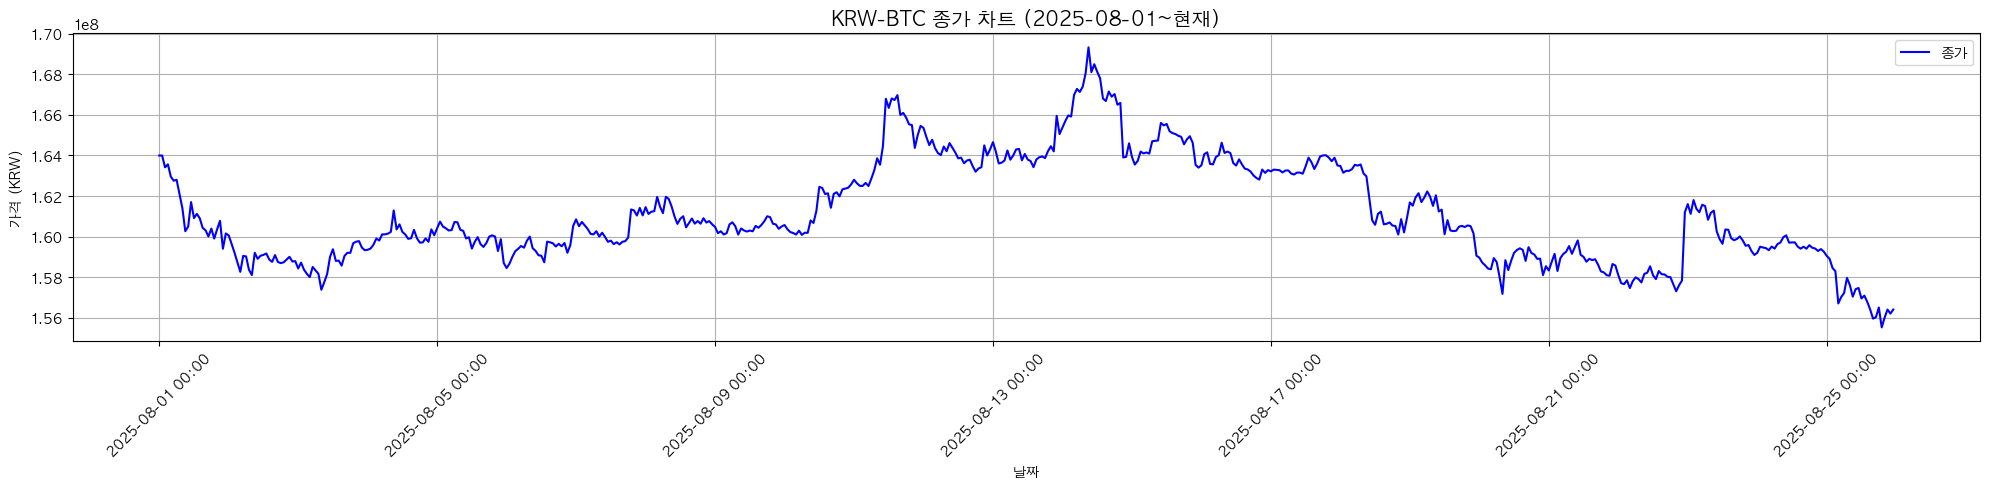

In [ ]:
import pyupbit
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates

mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 설정 값
ticker = "KRW-BTC"
start_date = "2025-08-01"
interval = "minute60" # 일봉

# ⏳ 반복 수집 준비
to = datetime.now()
all_data = []

# 🔁 200개씩 과거로 반복 수집
while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    print(f"🔄 Fetching data until {to.strftime('%Y-%m-%d %H:%M')}")

    if data is None or data.empty:
        break

    all_data.append(data)
    to = data.index[0]  # 더 과거 시점으로 이동

    if to < pd.to_datetime(start_date):
        break

# 🧹 정리
df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]  # 중복 제거
df = df.sort_index()
df = df[df.index >= pd.to_datetime(start_date)]
# print(df.head())

# 그래프 그리기(종가 기준)
plt.figure(figsize=(20, 5))
plt.plot(df.index, df["close"], label="종가", color='blue')

# ✅ x축 눈금 설정: 시간까지 표시되도록!
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동 눈금 간격
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # 날짜+시간 포맷
plt.xticks(rotation=45)

# 1. 종가 차트
plt.title(f"{ticker} 종가 차트 ({start_date}~현재)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("가격 (KRW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🔄 Fetching data until 2025-08-25 23:31
🔄 Fetching data until 2025-07-23 17:00


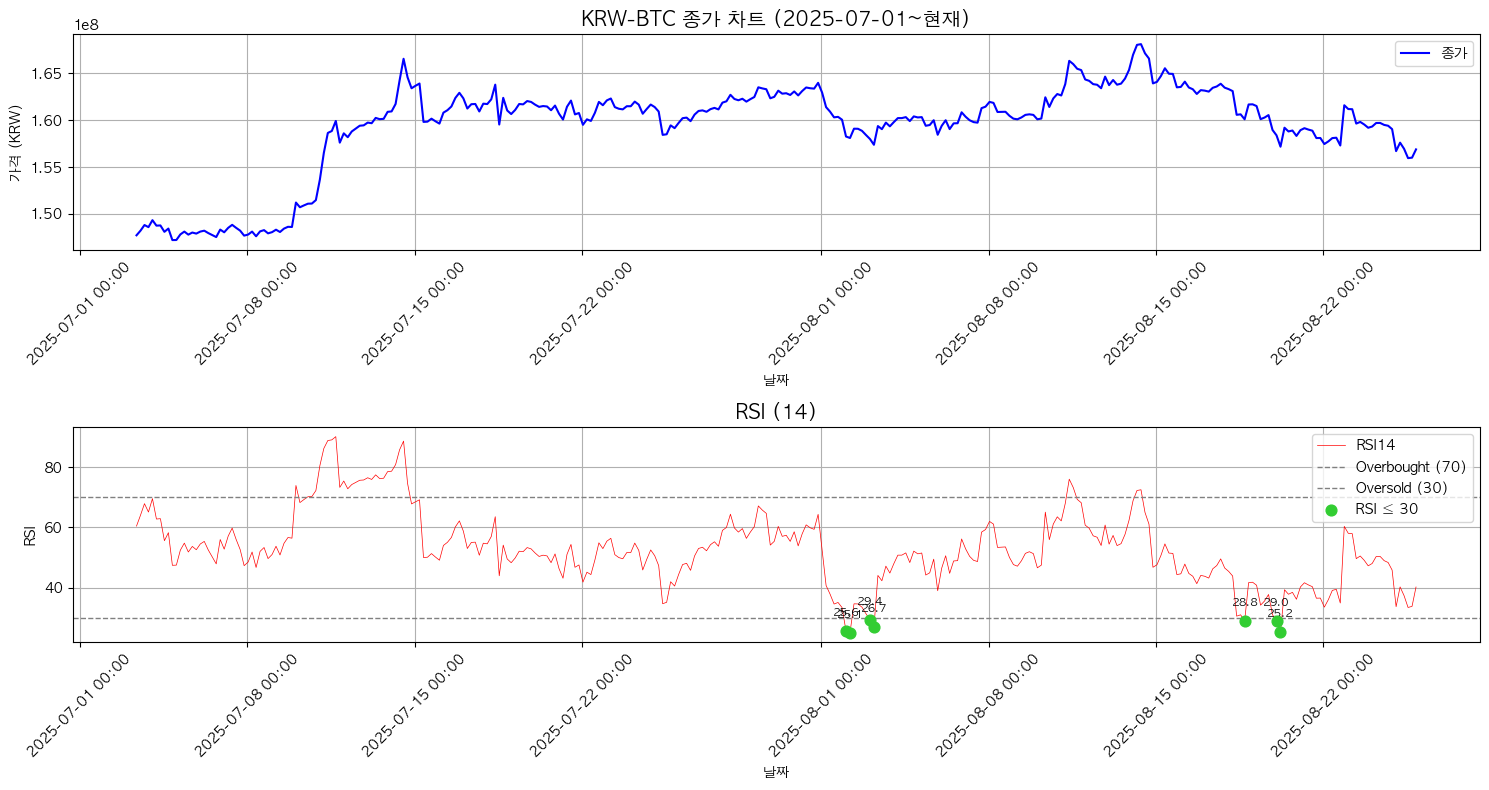

In [47]:
import pyupbit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime

# 🔧 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 설정
ticker = "KRW-BTC"
start_date = "2025-07-01"
interval = "minute240"

# 📦 반복 수집
to = datetime.now()
all_data = []

while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    print(f"🔄 Fetching data until {to.strftime('%Y-%m-%d %H:%M')}")

    if data is None or data.empty:
        break

    all_data.append(data)
    to = data.index[0]
    if to < pd.to_datetime(start_date):
        break

# 🧹 정리
df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()
df = df[df.index >= pd.to_datetime(start_date)]

# 📈 RSI(14) 계산 (EMA 방식)
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

roll_up = pd.Series(gain, index=df.index).ewm(alpha=1/14, adjust=False).mean()
roll_down = pd.Series(loss, index=df.index).ewm(alpha=1/14, adjust=False).mean()

RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))
df["RSI14"] = RSI

# ✅ 앞부분 14개는 제거 (초기값 불안정)
df = df.iloc[14:]



# 📊 그래프: 2단 구성
plt.figure(figsize=(15, 8))

# 1. 종가 차트
plt.subplot(2, 1, 1)
plt.plot(df.index, df["close"], label="종가", color='blue')
plt.title(f"{ticker} 종가 차트 ({start_date}~현재)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("가격 (KRW)")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# 2. RSI 차트
plt.subplot(2, 1, 2)
plt.plot(df.index, df["RSI14"], label="RSI14", color='red', linewidth=0.5)
plt.axhline(70, color='gray', linestyle='--', linewidth=1, label="Overbought (70)")
plt.axhline(30, color='gray', linestyle='--', linewidth=1, label="Oversold (30)")

# ✅ RSI 30 돌파 지점 점 찍기
# crosses = (df["RSI14"].shift(1) <= 30) & (df["RSI14"] > 30)
# df_cross = df[crosses]
# plt.scatter(df_cross.index, df_cross["RSI14"], color='green', s=50, label="RSI 30 돌파", zorder=5)

# ✅ RSI 30 이하 지점 표시
oversold = df[df["RSI14"] <= 30]
plt.scatter(oversold.index, oversold["RSI14"], color='limegreen', s=60, label="RSI ≤ 30", zorder=5)

# ✅ 각 점에 RSI 값 텍스트 추가
for idx, value in zip(oversold.index, oversold["RSI14"]):
    plt.text(idx, value + 5, f"{value:.1f}", color='black', fontsize=8, ha='center')  
    # value+1 은 숫자가 점 위에 살짝 뜨도록

plt.title("RSI (14)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("RSI")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


🔄 Fetching data until 2025-08-26 00:06


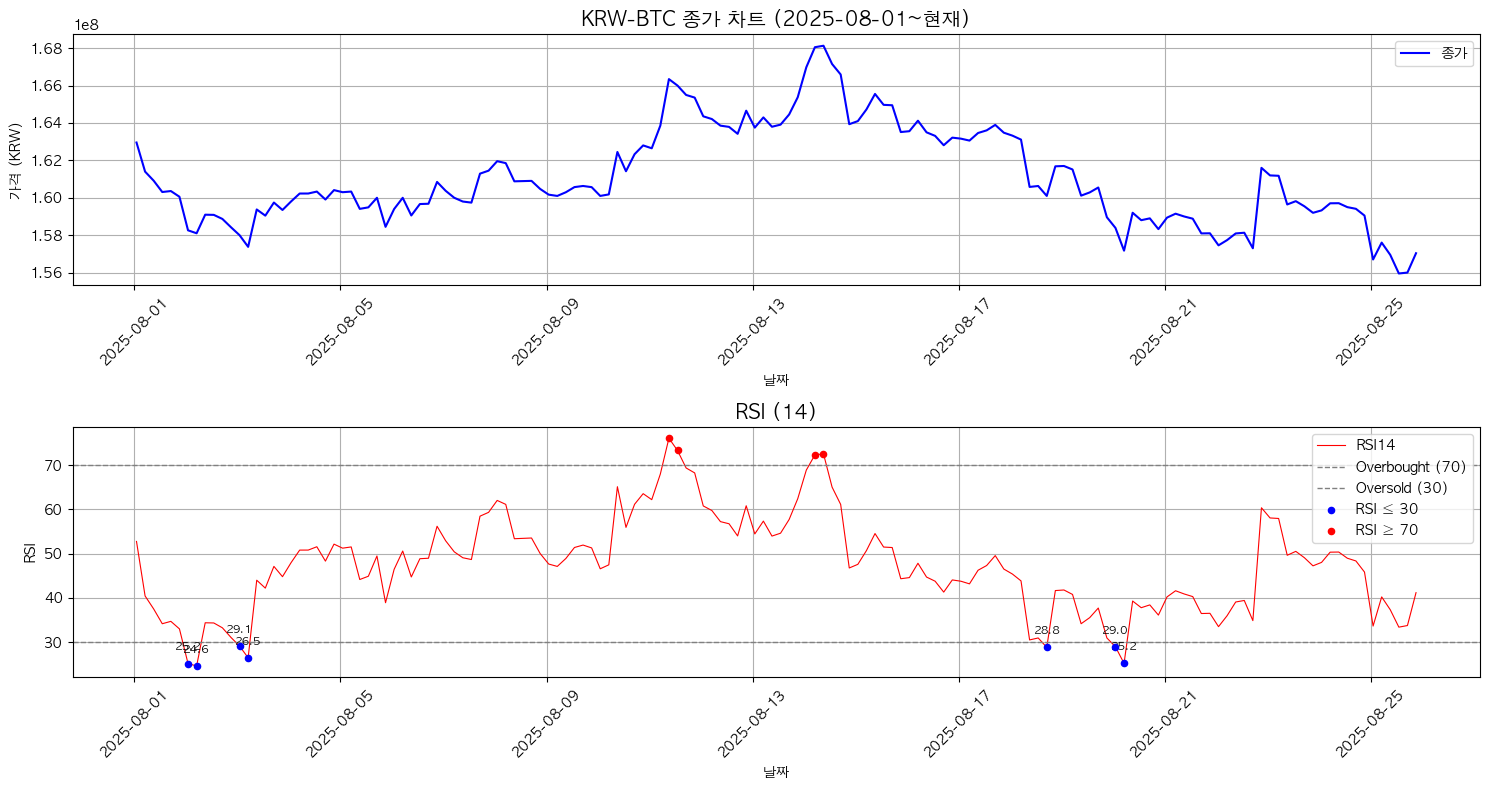

In [ ]:
import pyupbit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 🔧 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# ==============================
# 설정
ticker = "KRW-BTC"
start_date = "2025-08-01"
interval = "minute240"   # 4시간봉
period = 14              # RSI 기간
bot_interval = 30  # 봇 실행 주기 (분 단위)
# ==============================

# ✅ 시작 날짜보다 앞의 데이터를 더 가져오기 (RSI 초기화용)
candles_per_day = 24 * 60 // 240   # 4시간봉 = 하루 6개
extra_days = period // candles_per_day + 2   # 여유로 며칠 더 확보
real_start = pd.to_datetime(start_date) - timedelta(days=extra_days)

# 📦 반복 수집
to = datetime.now()
all_data = []

while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    print(f"🔄 Fetching data until {to.strftime('%Y-%m-%d %H:%M')}")

    if data is None or data.empty:
        break

    all_data.append(data)
    to = data.index[0]
    if to < real_start:
        break

# 🧹 정리
df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()

# 📈 RSI(14) 계산 (EMA 방식, Wilder's smoothing)
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

roll_up = pd.Series(gain, index=df.index).ewm(alpha=1/period, adjust=False).mean()
roll_down = pd.Series(loss, index=df.index).ewm(alpha=1/period, adjust=False).mean()

RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))
df["RSI14"] = RSI

# ✅ 최종적으로 start_date 이후 데이터만 시각화
df = df[df.index >= pd.to_datetime(start_date)]

# 📊 그래프: 2단 구성
plt.figure(figsize=(15, 8))

# 1. 종가 차트
plt.subplot(2, 1, 1)
plt.plot(df.index, df["close"], label="종가", color='blue')
plt.title(f"{ticker} 종가 차트 ({start_date}~현재)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("가격 (KRW)")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # ('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# 2. RSI 차트
plt.subplot(2, 1, 2)
plt.plot(df.index, df["RSI14"], label="RSI14", color='red', linewidth=0.8)
plt.axhline(70, color='gray', linestyle='--', linewidth=1, label="Overbought (70)")
plt.axhline(30, color='gray', linestyle='--', linewidth=1, label="Oversold (30)")

# ✅ RSI 30 이하 지점 강조 + 값 표시
oversold = df[df["RSI14"] <= 30]
plt.scatter(oversold.index, oversold["RSI14"], color='blue', s=20, label="RSI ≤ 30", zorder=5)

# ✅ RSI 70 이상 지점 강조 + 값 표시
overbought = df[df["RSI14"] >= 70]
plt.scatter(overbought.index, overbought["RSI14"], color='red', s=20, label="RSI ≥ 70", zorder=5)

for idx, value in zip(oversold.index, oversold["RSI14"]):
    plt.text(idx, value + 3, f"{value:.1f}", color='black', fontsize=8, ha='center')

plt.title("RSI (14)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("RSI")
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 200000원 | 잔액: 800000원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 160000원 | 잔액: 640000원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 128000원 | 잔액: 512000원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 102400원 | 잔액: 409600원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 81920원 | 잔액: 327680원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 65536원 | 잔액: 262144원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 52429원 | 잔액: 209715원
[매수] 2025-08-02 01:00:00 | 가격: 158260000원 | 금액: 41943원 | 잔액: 167772원
[매수] 2025-08-02 05:00:00 | 가격: 158102000원 | 금액: 33554원 | 잔액: 134218원
[매수] 2025-08-02 05:00:00 | 가격: 158102000원 | 금액: 26844원 | 잔액: 107374원
[매수] 2025-08-02 05:00:00 | 가격: 158102000원 | 금액: 21475원 | 잔액: 85899원
[매수] 2025-08-02 05:00:00 | 가격: 158102000원 | 금액: 17180원 | 잔액: 68719원
[매수] 2025-08-02 05:00:00 | 가격: 158102000원 | 금액: 13744원 | 잔액: 54976원
[매수] 2025-08-02 05:00:00 | 가격: 158102000원 | 금액: 10995원 | 잔액: 43980원
[매수] 2025-08-02 05:00:00 | 가격: 158

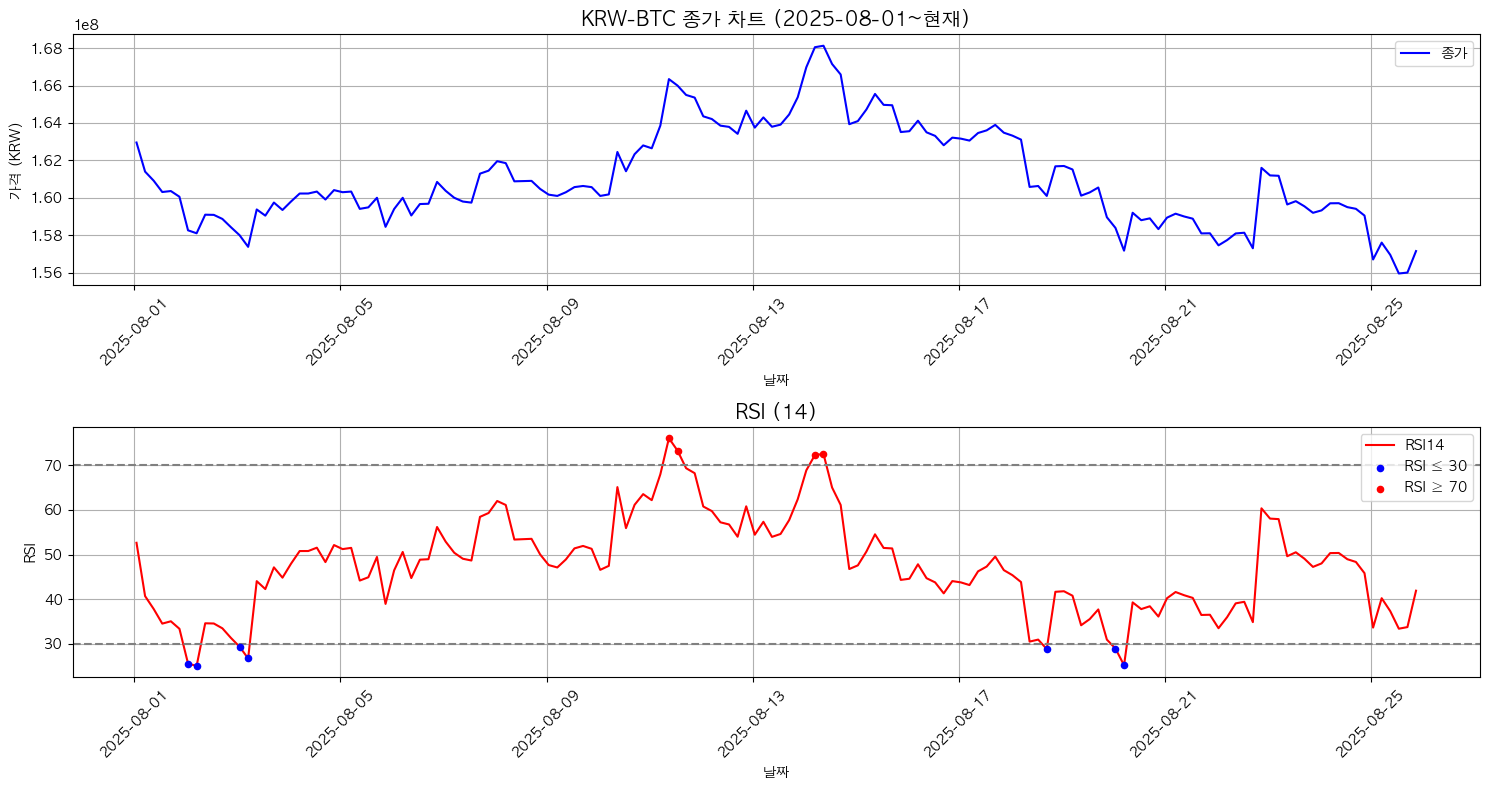

In [75]:
import pyupbit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 🔧 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# ==============================
# 설정
ticker = "KRW-BTC"
start_date = "2025-08-01"
interval = "minute240"   # 4시간봉
period = 14              # RSI 기간
bot_interval = 30        # 봇 실행 주기 (분 단위)
initial_capital = 1_000_000
min_trade = 5000
fee = 0.0005
# ==============================

# ✅ interval_minutes 자동 추출
if interval.startswith("minute"):
    interval_minutes = int(interval.replace("minute", ""))
else:
    raise ValueError(f"지원하지 않는 interval 형식입니다: {interval}")

# ✅ 14일치 데이터를 확보해서 안정적인 RSI 계산
real_start = pd.to_datetime(start_date) - timedelta(days=period)

# 📦 OHLCV 수집
to = datetime.now()
all_data = []

while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    if data is None or data.empty:
        break
    all_data.append(data)
    to = data.index[0]
    if to < real_start:
        break

# 🧹 정리
df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()

# 📈 RSI 계산
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
roll_up = pd.Series(gain, index=df.index).ewm(alpha=1/period, adjust=False).mean()
roll_down = pd.Series(loss, index=df.index).ewm(alpha=1/period, adjust=False).mean()
RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))
df["RSI14"] = RSI

# ✅ NaN 제거 + start_date 이후만 시뮬레이션 대상
df = df.dropna(subset=["RSI14"])
df = df[df.index >= pd.to_datetime(start_date)]

# 💰 시뮬레이션
capital = initial_capital
position = 0.0
avg_buy_price = 0.0

start_time = df.index[0]
end_time = df.index[-1]
bot_times = pd.date_range(start=start_time, end=end_time, freq=f"{bot_interval}min")
timestamps = df.index
executions = 0

for current_time in bot_times:
    idx_arr = timestamps.get_indexer([current_time], method="ffill")
    if idx_arr[0] == -1:
        continue
    idx = idx_arr[0]
    if idx == 0 or idx >= len(df):
        continue

    executions += 1
    rsi = df["RSI14"].iloc[idx]
    price = df["close"].iloc[idx]

    # ✅ 매수 조건
    if rsi <= 30 and capital > 0:
        invest_amount = capital * 0.2
        if invest_amount < min_trade:
            continue
        btc_amount = (invest_amount * (1 - fee)) / price
        total_cost = (avg_buy_price * position) + invest_amount
        position += btc_amount
        avg_buy_price = total_cost / position
        capital -= invest_amount
        print(f"[매수] {df.index[idx]} | 가격: {price:.0f}원 | 금액: {invest_amount:.0f}원 | 잔액: {capital:.0f}원")

    # ✅ 매도 조건
    elif rsi >= 70 and position > 0 and avg_buy_price > 0:
        profit_rate = (price - avg_buy_price) / avg_buy_price * 100
        if profit_rate >= 5:
            sell_value = (position * price) * (1 - fee)
            capital += sell_value
            print(f"[매도] {df.index[idx]} | 가격: {price:.0f}원 | 평가금액: {sell_value:,.0f}원 | 수익률: {profit_rate:.2f}%")
            position = 0.0
            avg_buy_price = 0.0

# 📊 최종 평가
final_price = df["close"].iloc[-1]
btc_value = position * final_price
final_asset = capital + btc_value
total_return = (final_asset - initial_capital) / initial_capital * 100

print("="*50)
print(f"💰 초기 자산: {initial_capital:,.0f} 원")
print(f"📦 보유 BTC: {position:.6f} BTC")
print(f"📈 현재 BTC 가격: {final_price:,.0f} 원")
print(f"🏦 BTC 평가금액: {btc_value:,.0f} 원")
print(f"🪙 최종 자산: {final_asset:,.0f} 원")
print(f"📈 총 수익률: {total_return:.2f}%")
print(f"⏱ 총 실행 횟수: {executions} 회")
print("="*50)

# 📊 그래프
plt.figure(figsize=(15, 8))

# 1. 종가 차트
plt.subplot(2, 1, 1)
plt.plot(df.index, df["close"], label="종가", color='blue')
plt.title(f"{ticker} 종가 차트 ({start_date}~현재)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("가격 (KRW)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 2. RSI 차트
plt.subplot(2, 1, 2)
plt.plot(df.index, df["RSI14"], label="RSI14", color='red')
plt.axhline(70, color='gray', linestyle='--')
plt.axhline(30, color='gray', linestyle='--')

# ✅ RSI 점 포인트 강조
oversold = df[df["RSI14"] <= 30]
overbought = df[df["RSI14"] >= 70]
plt.scatter(oversold.index, oversold["RSI14"], color='blue', s=20, label="RSI ≤ 30", zorder=5)
plt.scatter(overbought.index, overbought["RSI14"], color='red', s=20, label="RSI ≥ 70", zorder=5)

plt.title("RSI (14)", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("RSI")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()
